In [5]:
import pandas as pd

In [6]:
timeseries_df = pd.read_csv('/home/npruitt/repos/csv_files/express_app_load_test_timeseries_data.csv')

In [7]:
timeseries_df.head()

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
0,http_reqs,1690667868,1.000000,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
1,http_req_duration,1690667868,30.533006,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
2,http_req_blocked,1690667868,0.510090,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
3,http_req_connecting,1690667868,0.326767,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN
4,http_req_tls_handshaking,1690667868,0.000000,NaN,NaN,NaN,True,NaN,GET,http://127.0.0.1:3000/person/1,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://127.0.0.1:3000/person/1,NaN,NaN


In [16]:
timeseries_df = timeseries_df[['metric_name', 'timestamp', 'metric_value']]

In [23]:
timeseries_df = timeseries_df[timeseries_df['metric_name'] == 'http_req_duration'][['timestamp', 'metric_value']]

In [26]:
http_duration_timeseries_df = timeseries_df.groupby(timeseries_df['timestamp']).median()

In [31]:
# create 'timestamp' column out of index
http_duration_timeseries_df = http_duration_timeseries_df.reset_index()

<Axes: xlabel='timestamp'>

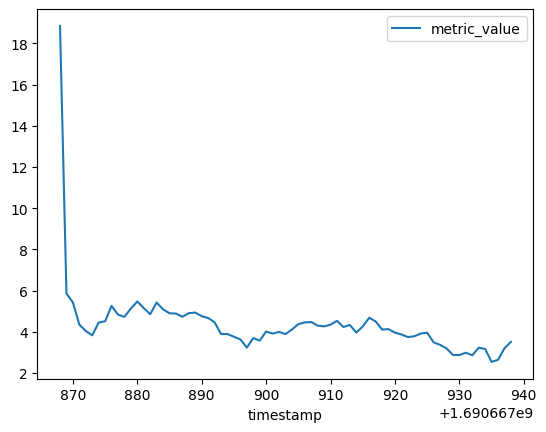

In [33]:
http_duration_timeseries_df.plot(x='timestamp', y='metric_value')

In [ ]:
# Rudimentary timeseries plot. Can I use matplotlib to create a better one with the x-axis tick marks to be 'seconds'
# into test?